In [25]:
import nsaba.nsaba as na
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import scipy as sp
import random as rn
import time

import matplotlib as mt
import matplotlib.pyplot as plt
mt.style.use('ggplot')
%matplotlib inline

In [2]:
dd = '../../data_dir'
na.Nsaba.aba_load(dd)
na.Nsaba.ns_load(dd)

This may take a minute or two ...
SampleAnnot.csv loaded.
MicroarrayExpression.csv loaded.
Probes.csv loaded.
Nsaba.aba['mni_coords'] initialized.

This may take a minute or two ...
database.txt loaded.
features.txt loaded.
Nsaba.ns['mni_coords'] initialized.



In [3]:
na.Nsaba.ns_load_id_dict()

This may take a minute or two ...


In [4]:
para = na.Nsaba()
para.load_ge_pickle('Nsaba_ABA_ge.pkl', dd)

This may take a minute or two ...
'ge' dictionary successfully loaded


In [145]:
feat_df = para.get_ns_struct("features_df")

## Term Activation

In [5]:
_, df = para._term_to_coords('reward', -1)

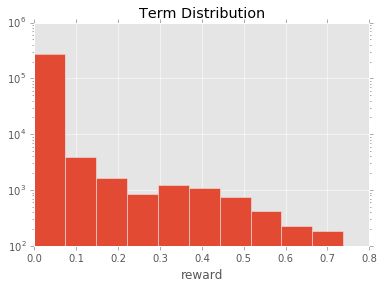

In [6]:
df.reward.hist(bins=10);
plt.title("Term Distribution");
plt.yscale('log')
plt.xlabel('reward');

In [7]:
X = df.loc[:, 'x':'z'].as_matrix()
y = df.loc[:, 'reward'].as_matrix()

### Random Forests

In [289]:
%%time
clf = RandomForestRegressor(n_estimators=50, n_jobs=4)
clf.fit(X,y)

CPU times: user 38.8 s, sys: 435 ms, total: 39.3 s
Wall time: 10.7 s


In [186]:
%%time
# For comparison with NSABA KNN
para.get_ns_act(term='reward', k=10)

This may take a few minutes...
CPU times: user 22.8 s, sys: 1.9 s, total: 24.7 s
Wall time: 25 s


### Residual Analysis

In [279]:
packer = lambda x,y: [[list(el),y] for el in x]

In [356]:
def Xy_split(mat):
    X = []
    y = []
    for row in mat:
        X.append(row[0])
        y.append(row[1])
        
    return np.array(X), np.array(y)

In [366]:
A_validation = []
R_validation = []

top_id_coords = para.term_to_coords('reward', 8)
for pmid, coords in top_id_coords:
    A_validation += packer(coords, feat_df.loc[feat_df.pmid == pmid, "reward"].iloc[0])

R_validation = rn.sample(zip(X,y), 1000)

Ax, Ay = Xy_split(A_validation)
Rx, Ry = Xy_split(R_validation)

In [367]:
ApredRF = clf.predict(Ax)
RpredRF = clf.predict(Rx)

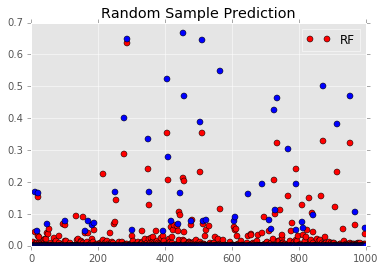

In [368]:
plt.plot(RpredRF, 'ro', label="RF");
plt.plot(Ry, 'bo')
plt.title("Random Sample Prediction");
plt.legend();

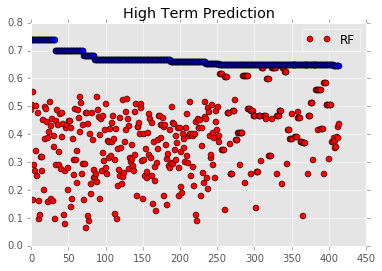

In [369]:
plt.plot(ApredRF, 'ro', label='RF');
plt.plot(Ay, 'bo');
plt.title("High Term Prediction");
plt.legend();

In [370]:
Rpred = para.coords_to_ns_act(Rx, 'reward')

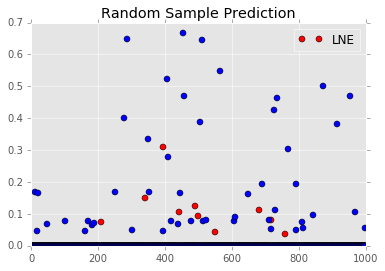

In [371]:
# Local Neighbors Estimate
plt.plot(Rpred, 'ro', label="LNE");
plt.plot(Ry, 'bo')
plt.title("Random Sample Prediction");
plt.legend();

In [372]:
Apred = para.coords_to_ns_act(Ax, 'reward')

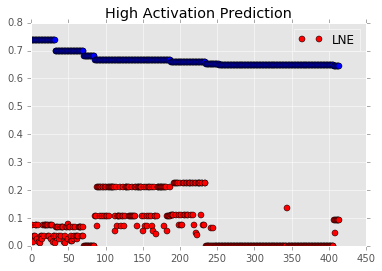

In [373]:
plt.plot(Apred, 'ro', label='LNE');
plt.plot(Ay, 'bo');
plt.title("High Activation Prediction");
plt.legend();

In [375]:
print "RF Random Sample Validation: %f" % np.sum(np.abs(RpredRF - Ry))
print "LNE Random Sample Validation: %f" % np.sum(np.abs(Rpred - Ry))
print "RF High Activation Validation: %f" % np.sum(np.abs(ApredRF - Ay))
print "LNE High Activation Validation: %f" % np.sum(np.abs(Apred - Ay))

RF Random Sample Validation: 9.114073
LNE Random Sample Validation: 11.661934
RF High Activation Validation: 114.123319
LNE High Activation Validation: 249.008267
